## Setup

In [277]:
import torch
import numpy as np
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as data
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import pandas as pd

from transformers import ViTModel, ViTImageProcessor

import timm
from linformer import Linformer
from vit_pytorch.efficient import ViT
import copy
from sklearn.metrics import classification_report, confusion_matrix


# Modelo 1 - VIT fine tunning last layer


## Leitura das imagens

In [4]:
elefante_path = '../Data/zebra_elephants/train/elephants/'

zebra_path = '../Data/zebra_elephants/train/zebras/'

In [5]:
class CargaImagens:

    def __init__(self, elefante_path, zebra_path):
        self.elefante_path = elefante_path
        self.zebra_path = zebra_path 

        self.zebra_imgs_list = [img for img in os.listdir(zebra_path) if img.endswith('.jpeg')]
        self.elefante_imgs_list = [img for img in os.listdir(elefante_path) if img.endswith('.jpeg')]


    def __len__(self):
        return len(self.zebra_imgs_list) + len(self.elefante_imgs_list) 
    
    def len_elefantes(self):
        return len(self.elefante_imgs_list)
     
    def len_zebras(self):
         return len(self.zebra_imgs_list) 
    
    def img_read(self, idx, animal = None):
        if animal == "zebra":
            return cv2.imread(os.path.join(self.zebra_path, self.zebra_imgs_list[idx]))
        
        elif animal == 'elefante':
            return cv2.imread(os.path.join(self.elefante_path, self.elefante_imgs_list[idx]))
        else:
            raise 'Incluir o animal'
        
    def verifica_dimensoes(self):
        shapes = [self.img_read(i, animal).shape 
                  for animal in ['elefante', 'zebra'] 
                  for i in range(self.len_elefantes() if animal =='elefante' else self.len_zebras())]

        return set(shapes)
    
    def show_imgs(self, idx, animal):
        self.ax = plt.imshow(cv2.cvtColor(self.img_read(idx, animal),cv2.COLOR_BGR2RGB))
        plt.title(f'{animal} - indice: {idx}')
        


        
carga = CargaImagens(elefante_path, zebra_path)

In [6]:
#carga.verifica_dimensoes()

{(330, 330, 3)}

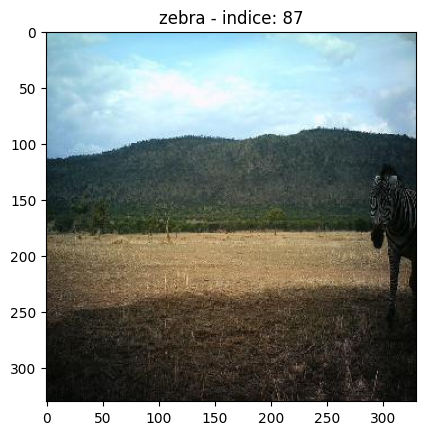

In [7]:
carga.show_imgs(87,"zebra")

In [2]:
dados_treino = torchvision.datasets.ImageFolder('../Data/zebra_elephants/train/', transform= torchvision.transforms.ToTensor())
dados_valid = torchvision.datasets.ImageFolder('../Data/zebra_elephants/valid/', transform= torchvision.transforms.ToTensor())
dados_teste = torchvision.datasets.ImageFolder('../Data/zebra_elephants/test/', transform= torchvision.transforms.ToTensor())

In [3]:
print(dados_treino, '\nClasses:', dados_treino.class_to_idx)
print('\n'+'='*50+'\n')
print(dados_valid, '\nClasses:', dados_valid.class_to_idx)
print('\n'+'='*50+'\n')
print(dados_teste)

Dataset ImageFolder
    Number of datapoints: 13529
    Root location: ../Data/zebra_elephants/train/
    StandardTransform
Transform: ToTensor() 
Classes: {'elephants': 0, 'zebras': 1}


Dataset ImageFolder
    Number of datapoints: 470
    Root location: ../Data/zebra_elephants/valid/
    StandardTransform
Transform: ToTensor() 
Classes: {'elephants': 0, 'zebras': 1}


Dataset ImageFolder
    Number of datapoints: 5999
    Root location: ../Data/zebra_elephants/test/
    StandardTransform
Transform: ToTensor()


## Classe do Modelo

### VIT


[Hugging Face - VIT documentation](https://huggingface.co/google/vit-base-patch16-224)

In [11]:
# Hiperparâmetros
EPOCHS = 5
BATCH_SIZE = 10
LEARNING_RATE = 1e-08
DEVICE = torch.device('cuda')

In [5]:
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')


In [12]:
dl_treino = data.DataLoader(dados_treino, batch_size = BATCH_SIZE, shuffle = True,  num_workers = 8)
dl_valid  = data.DataLoader(dados_valid, batch_size = BATCH_SIZE, shuffle = True, num_workers = 8)
dl_teste  = data.DataLoader(dados_teste, batch_size = BATCH_SIZE, shuffle = True, num_workers = 8)  

In [7]:
class ViTImageClassifier(nn.Module):

    def __init__(self, num_labels = 2):
        super(ViTImageClassifier, self).__init__()

        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.vit.config.hidden_size, num_labels)
        self.num_labels = num_labels

    def forward(self, pixel_values, labels):
        outputs = self.vit(pixel_values = pixel_values)
        output = self.dropout(outputs.last_hidden_state[:,0])

        logits = self.classifier(output)
        loss = None

        if labels is not None:
            loss_function = nn.CrossEntropyLoss()
            loss = loss_function(logits.view(-1, self.num_labels), labels.view(-1))
            
        if loss is not None:
            return logits, loss.item()
        else:
            return logits, None



In [13]:
modelo = ViTImageClassifier()
modelo.cuda()

# Otimizador Adam
optimizer = torch.optim.Adam(modelo.parameters(), lr = LEARNING_RATE)

# Cross Entropy Loss
loss_func = nn.CrossEntropyLoss()

## Treinamento

In [17]:
%%time
for epoch in range(EPOCHS):        
    modelo.train()
    for step, (x, y) in enumerate(dl_treino):
        # Altera a matriz de entrada para uma lista com cada lote sendo um elemento
        x = torch.stack([torch.tensor(processor(img, do_rescale=True)['pixel_values'][0]) for img in x])
         
        # Envia para o device
        x, y = x.to(DEVICE), y.to(DEVICE)
        
        # batch x (imagem)
        b_x = Variable(x)  
        
        # batch y (target, ou seja, classe)
        b_y = Variable(y)   
        
        # Alimenta o modelo e extrai a previsão e o erro
        output, loss = modelo(b_x, None)
        
         # Calcula o erro final e aplica o backpropagation (otimização)
        if loss is not None: 
            loss = loss_func(output, b_y)   
            optimizer.zero_grad()           
            loss.backward()                 
            optimizer.step()
            
        # Print dos valores intermediários
        if step % 50 == 0:
            
            # Obtém o próximo lote para fins de validação
            valida = next(iter(dl_valid))
            valida_x = valida[0]
            
            # Reshape para obter matrizes de recursos conforme necessário
            valida_x = np.split(np.squeeze(np.array(valida_x)), BATCH_SIZE)
            
            for index, array in enumerate(valida_x):
                valida_x[index] = np.squeeze(array)
            
            # Gera o tensor com dados de validação em x
            valida_x = torch.tensor(np.stack(processor(valida_x)['pixel_values'], axis = 0))
            
            # Envia para o device
            valida_x = valida_x.to(DEVICE)
            valida_y = valida[1].to(DEVICE)
            
            # Obtém a saída do modelo (respectiva classe) 
            test_output, loss = modelo(valida_x, valida_y)
            
            # A saída final é o valor de maior probabilidade
            test_output = test_output.argmax(1)
            
            # Calcula a acurácia
            accuracy = (test_output == valida_y).sum().item() / BATCH_SIZE
            
            print('Epoch: ', epoch, '| Erro em Treino: %.4f' % loss, '| Acurácia em Validação: %.2f' % accuracy)
    

Epoch:  0 | Erro em Treino: 0.6913 | Acurácia em Validação: 0.50
Epoch:  0 | Erro em Treino: 0.7032 | Acurácia em Validação: 0.30
Epoch:  0 | Erro em Treino: 0.6888 | Acurácia em Validação: 0.50


KeyboardInterrupt: 

In [18]:
# Loop de treino
for epoch in range(EPOCHS):
    modelo.train()
    
    for step, (x, y) in enumerate(dl_treino):
        # Aplica o extrator de recursos 
        x = torch.stack([torch.tensor(processor(img, do_rescale=True)['pixel_values'][0]) for img in x])
        
        # Envia para o device
        x, y = x.to(DEVICE), y.to(DEVICE)
        
        # batch x (imagem)
        b_x = Variable(x)  
        
        # batch y (target, ou seja, classe)
        b_y = Variable(y)   
        
        # Alimenta o modelo e extrai a previsão e o erro
        output, loss = modelo(b_x, None)
        
        # Calcula o erro final e aplica o backpropagation (otimização)
        if loss is not None: 
            loss = loss_func(output, b_y)
            optimizer.zero_grad()           
            loss.backward()                 
            optimizer.step()
    
        # Print dos valores intermediários
        if step % 50 == 0:
            modelo.eval()
            with torch.no_grad():
                valida = next(iter(dl_valid))
                valida_x, valida_y = valida[0], valida[1]
                
                valida_x = torch.stack([torch.tensor(processor(img, do_rescale=True)['pixel_values'][0]) for img in valida_x])
                
                valida_x, valida_y = valida_x.to(DEVICE), valida_y.to(DEVICE)
                
                # Obtém a saída do modelo (respectiva classe) 
                test_output, loss = modelo(valida_x, valida_y)
                
                # A saída final é o valor de maior probabilidade
                test_output = test_output.argmax(1)
                
                # Calcula a acurácia
                accuracy = (test_output == valida_y).sum().item() / BATCH_SIZE
                
                print(f'Epoch: {epoch} | Erro em Treino: {loss:.4f} | Acurácia em Validação: {accuracy:.2f}')


Epoch: 0 | Erro em Treino: 0.6890 | Acurácia em Validação: 0.60
Epoch: 0 | Erro em Treino: 0.6975 | Acurácia em Validação: 0.40
Epoch: 0 | Erro em Treino: 0.6975 | Acurácia em Validação: 0.40


KeyboardInterrupt: 

## Avaliação e Deploy

In [95]:
# Salvando o modelo
torch.save(modelo, '../models/modelo_vit.pt')

In [96]:
modelo_vit = torch.load('../models/modelo_vit.pt')
modelo_vit.eval()

ViTImageClassifier(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=

In [108]:
loader_nova_imagem = data.DataLoader(dados_valid, batch_size = 1, shuffle = True, num_workers = 4) 

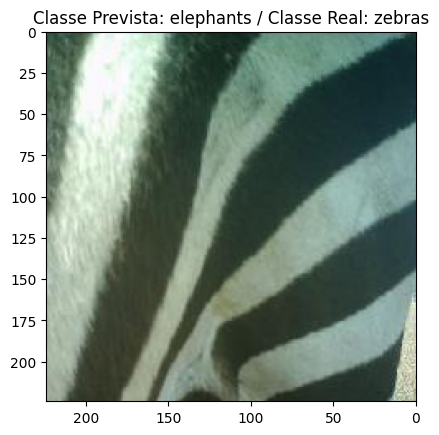

In [109]:
# Começamos desativando o track de gradientes, pois estamos em inferência e não em treino
with torch.no_grad():
    
    # Obtemos o input e a saída
    inputs, target = next(iter(loader_nova_imagem))
    originalInput = inputs[0].permute(1, 2, 0)
    
    # Reshape dos dados
    #inputs = inputs[0].permute(1, 2, 0)
    #
    ## Guarda o input original
    #originalInput = inputs
    #
    ## Reshape
    #for index, array in enumerate(inputs):
    #    inputs[index] = np.squeeze(array)
    #
    # Grava os inputs como tensor
    #inputs = torch.tensor(np.stack(processor(inputs)['pixel_values'], axis = 0))
    inputs = torch.stack([torch.tensor(processor(img, do_rescale=True)['pixel_values'][0]) for img in inputs])

    # Envia para o device
    inputs = inputs.to(DEVICE)
    target = target.to(DEVICE)
 
    # Gera a previsão do modelo
    prediction, loss = modelo_vit(inputs, target)
    
    # A previsão final é a classe de maior probabilidade
    predicted_class = np.argmax(prediction.cpu())
    
    # Valor previsto
    classe_prevista = list(dados_valid.class_to_idx.keys())[list(dados_valid.class_to_idx.values()).index(predicted_class)]
    
    # Valor real
    classe_real = list(dados_valid.class_to_idx.keys())[list(dados_valid.class_to_idx.values()).index(target)]
        
    # Mostra o resultado
    plt.imshow(originalInput)
    plt.xlim(224,0)
    plt.ylim(224,0)
    plt.title(f'Classe Prevista: {classe_prevista} / Classe Real: {classe_real}')
    plt.show()

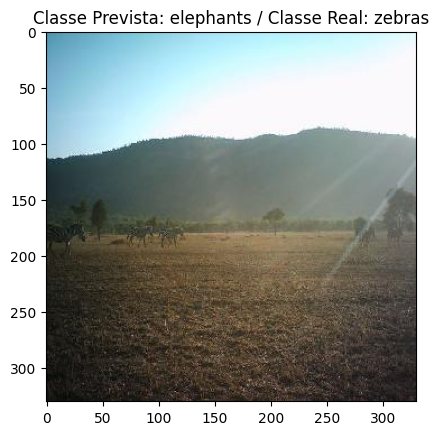

In [165]:
# Começamos desativando o track de gradientes, pois estamos em inferência e não em treino
with torch.no_grad():
    
    # Obtemos o input e a saída
    inputs, target = next(iter(loader_nova_imagem))
    
    # Guarda o input original para plotar
    original_input = inputs[0].permute(1, 2, 0).cpu().numpy()
    
    # Aplica o processador nas imagens de input
    processed_inputs = processor(images=inputs, return_tensors="pt")
    inputs = processed_inputs['pixel_values']
    
    # Envia para o device
    inputs = inputs.to(DEVICE)
    target = target.to(DEVICE)
 
    # Gera a previsão do modelo
    prediction, loss = modelo_vit(inputs, target)
    
    # A previsão final é a classe de maior probabilidade
    predicted_class = np.argmax(prediction.cpu())
    
    # Valor previsto
    classe_prevista = list(dados_valid.class_to_idx.keys())[list(dados_valid.class_to_idx.values()).index(predicted_class)]
    
    # Valor real
    classe_real = list(dados_valid.class_to_idx.keys())[list(dados_valid.class_to_idx.values()).index(target.item())]
        
    # Mostra o resultado
    plt.imshow(original_input)
    plt.title(f'Classe Prevista: {classe_prevista} / Classe Real: {classe_real}')
    plt.show()


# Modelo 2 - VIT Fine Tunning multiple layers


**Setup e hiperparametros**

In [208]:
torch.manual_seed(42)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

**Load data**

In [224]:
class load_dataset:

    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.img_data = None
        self.loader = None
        self.processor = None
        self.mean = None
        self.std = None
        self.train_loader = None
        self.val_loader = None

    def load_data(self):
        self.img_data = datasets.ImageFolder(self.data_dir, 
                                             transform=transforms.Compose([transforms.Resize((224, 224)), 
                                                                           transforms.ToTensor()]))
        
    def data_loader(self):
        self.loader = DataLoader(self.img_data, batch_size=64)
        return self.loader
        
    def calculate_mean_std(self):
        self.load_data()  # Certifique-se de que os dados estão carregados
        loader = self.data_loader()  # Cria o DataLoader
        mean = 0.0
        std = 0.0
        total_images_count = 0

        # Itera sobre todos os batches no DataLoader
        for i, (images, _) in enumerate(loader):
            # Número de imagens no lote
            batch_samples = images.size(0)
            total_images_count += batch_samples

            # Mover o lote para uma única dimensão
            images = images.view(batch_samples, images.size(1), -1)

            # Acumula a média e o desvio padrão
            mean += images.mean(2).sum(0)
            std += images.std(2).sum(0)

        # Verifica se alguma imagem foi processada
        if total_images_count == 0:
            raise ValueError("Nenhuma imagem foi encontrada no DataLoader.")

        # Divide pelo número total de imagens para obter a média e o desvio padrão do conjunto de dados inteiro
        mean /= total_images_count
        std /= total_images_count

        self.mean, self.std = mean, std

        return self.mean, self.std
    
    def dataloader_train_val(self):
        self.calculate_mean_std()  # Calcula a média e desvio padrão

        self.processor = {
            'train': transforms.Compose([transforms.Resize((224, 224)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(self.mean.tolist(), self.std.tolist())]),

            'valid': transforms.Compose([transforms.Resize((224, 224)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(self.mean.tolist(), self.std.tolist())])
        }
        
        # Recarrega os dados com as transformações de normalização aplicadas
        self.img_data = datasets.ImageFolder(self.data_dir, transform=self.processor['train'])
        
        # Calcula os tamanhos dos conjuntos de treino e validação
        len_dataset = len(self.img_data)
        train_size = int(len_dataset * 0.7)
        val_size = len_dataset - train_size

        print(f'O conjunto de dados possui um total de: {len_dataset} imagens\nE será dividido em {train_size} imagens de treino e {val_size} imagens para validação')
        
        # Divide os datasets
        self.train_dataset, self.val_dataset = random_split(self.img_data, [train_size, val_size])

        # Cria os DataLoaders
        self.train_loader = DataLoader(self.train_dataset, batch_size=64, shuffle=True, num_workers = 6)
        self.val_loader = DataLoader(self.val_dataset, batch_size=64, shuffle=False, num_workers = 6)

        return self.train_loader, self.val_loader
    



In [225]:
data_dir = '../Data/zebra_elephants/train'
dataset = load_dataset(data_dir)
train_loader, val_loader = dataset.dataloader_train_val()

O conjunto de dados possui um total de: 13999 imagens
E será dividido em 9799 imagens de treino e 4200 imagens para validação


In [142]:
dataloaders = {'train': train_loader, 'valid': val_loader}
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x1fd89bf5b80>,
 'valid': <torch.utils.data.dataloader.DataLoader at 0x1fd825e9760>}

In [134]:
# Obtém um batch de dados de treino
inputs, labels = next(iter(train_loader))

In [135]:
# Converte o batch em tensor numpy
inputs = inputs.numpy()
labels = labels.numpy()

In [168]:
# Nomes das categorias
class_names = dataset.img_data.classes
qtd_classes = len(class_names)
label_names = [class_names[label] for label in labels]

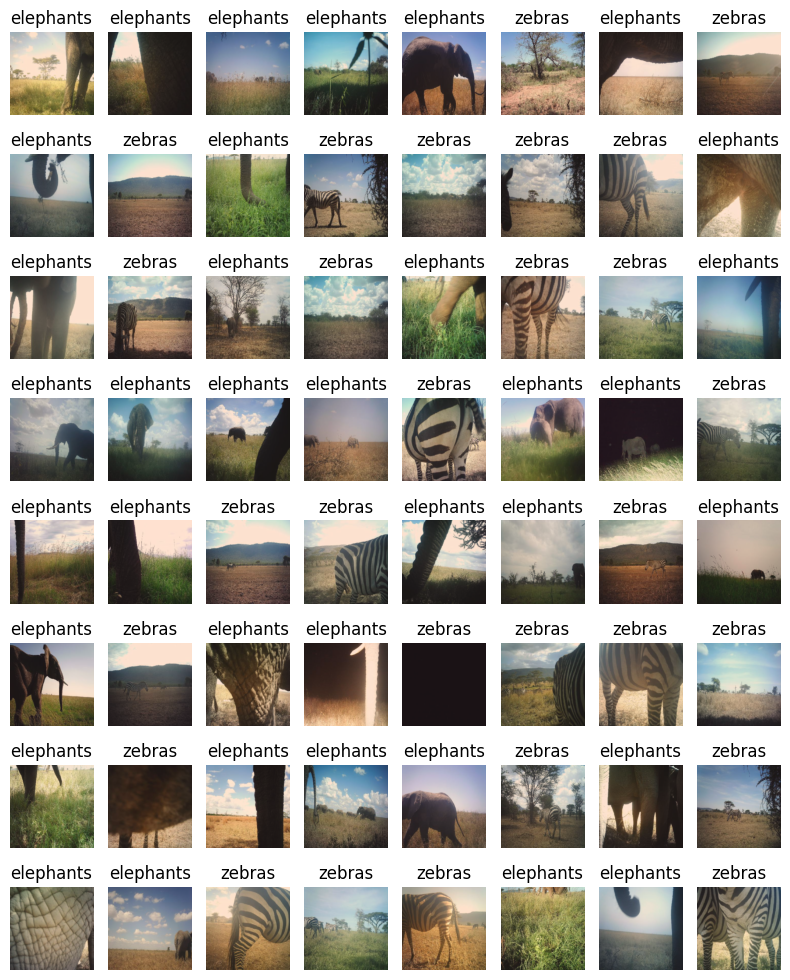

In [159]:
# Visualiza imagens e labels
fig, axes = plt.subplots(figsize = (8, 10), nrows = 8, ncols = 8)
axes = axes.flatten()

# Loop for
for i, (image, label) in enumerate(zip(inputs, label_names)):
    image = np.transpose(image, (1, 2, 0))  
    image = (image * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]  
    image = np.clip(image, 0, 1)  
    axes[i].imshow(image)
    axes[i].axis('off')
    axes[i].set_title(label)

plt.tight_layout()
plt.show()

In [199]:
class CarregaModeloCustom():
    def __init__(self, qtd_classes, model_name='vit_base_patch16_224', pretrained=True):
        """
        Inicializa a classe CarregaModeloVitCustom.

        Args:
        - qtd_classes (int): Número de classes de saída para a cabeça do modelo.
        - model_name (str): Nome do modelo ViT a ser carregado (padrão: 'vit_base_patch16_224').
        - pretrained (bool): Se True, carrega pesos pré-treinados (padrão: True).
        """
        self.qtd_classes = qtd_classes
        self.model_name = model_name
        self.pretrained = pretrained
        self.modelo = self._carrega_modelo()

    def _carrega_modelo(self):
        """
        Carrega o modelo ViT com a cabeça ajustada para o número de classes de saída.

        Returns:
        - modelo (nn.Module): Modelo ViT com a cabeça ajustada.
        """
        print(f"Carregando o modelo {self.model_name} com pesos pré-treinados: {self.pretrained}")
        modelo = timm.create_model(self.model_name, pretrained=self.pretrained)
        try:
            num_ftrs = modelo.head.in_features
            modelo.head = nn.Linear(num_ftrs, self.qtd_classes)
            print(f"Modelo {self.model_name} carregado com sucesso. Cabeça ajustada para {self.qtd_classes} classes.")
        except AttributeError as e:
            num_ftrs = modelo.classifier.in_features
            modelo.classifier = nn.Linear(num_ftrs, self.qtd_classes)
            
        except Exception as e:
            print(f"Erro ao carregar o modelo {self.model_name}: {e}")
            raise
        return modelo


In [202]:
model = CarregaModeloCustom(qtd_classes)

Carregando o modelo vit_base_patch16_224 com pesos pré-treinados: True
Modelo vit_base_patch16_224 carregado com sucesso. Cabeça ajustada para 2 classes.


In [210]:
# Atributos de entrada
in_features = 128

# Cria o objeto Linformer com os parâmetros de customização
efficient_transformer = Linformer(dim = in_features, seq_len = 49+1, depth = 12, heads = 8, k = 64)

# Define o modelo com os parâmetros de customização
modelo = ViT(dim = in_features,
             image_size = 224,
             patch_size = 32,
             num_classes = 2,
             transformer = efficient_transformer,
             channels = 3)

# Número de atributos
num_ftrs = in_features

# Modificamos a última camada de acordo com a tarefa de classificação
modelo.head = nn.Linear(num_ftrs, len(class_names))

# Envia o modelo para o device
modelo = modelo.to(DEVICE)

In [211]:
# Calcula o número de parâmetros do modelo
model_parameters = filter(lambda p: p.requires_grad, modelo.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

In [219]:
# Função de erro
criterion = nn.CrossEntropyLoss()

# Otimizador
optimizer = torch.optim.Adam(modelo.parameters(), lr = 3e-5)

# Learning rate scheduler
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 0.1)

# Parâmetros de controle
num_epochs = 15
best_model_wts = copy.deepcopy(modelo.state_dict())
best_acc = 0.0

In [217]:
# Listas para o histórico de treino
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

In [232]:
# Tamanhos dos datasets
dataset_sizes = {'train': len(dataset.train_dataset), 'valid': len(dataset.val_dataset)}

In [233]:
%%time
for epoch in range(num_epochs):
    
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # Define qual fase estamos, treino ou validação
    for phase in ['train', 'valid']:
        if phase == 'train':
            modelo.train() 
        else:
            modelo.eval()  

        # Contadores
        running_loss = 0.0
        running_corrects = 0

        # Iteração pelos dados
        for inputs, labels in dataloaders[phase]:
            
            # Envia imagens e labels para o device
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            # Zera os gradientes
            optimizer.zero_grad()

            # Forward propagation
            with torch.set_grad_enabled(phase == 'train'):
                
                # Faz as previsões com o modelo
                outputs = modelo(inputs)
                
                # Obtém a maior probabilidade de classe
                _, preds = torch.max(outputs, 1)
                
                # Calcula o erro
                loss = criterion(outputs, labels)

                # Backpropagation e optimization somente em treino
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # Calcula as estatísticas
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        # Calcula erro e acurácia
        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = (running_corrects.double() / dataset_sizes[phase]).item()

        # Grava o histórico
        if phase == 'train':
            train_loss_history.append(epoch_loss)
            train_acc_history.append(epoch_acc)
        else:
            val_loss_history.append(epoch_loss)
            val_acc_history.append(epoch_acc)

        print('{} - Erro: {:.4f} Acurácia: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        # Deep copy do modelo
        if phase == 'valid' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(modelo.state_dict())

    print()

print('\nMelhor Acurácia em Validação: {:4f}'.format(best_acc))
print('\nTreinamento Concluído')

Epoch 0/14
----------
train - Erro: 0.1892 Acurácia: 0.9261
valid - Erro: 0.1703 Acurácia: 0.9350

Epoch 1/14
----------
train - Erro: 0.1424 Acurácia: 0.9487
valid - Erro: 0.1527 Acurácia: 0.9433

Epoch 2/14
----------
train - Erro: 0.1109 Acurácia: 0.9603
valid - Erro: 0.1639 Acurácia: 0.9419

Epoch 3/14
----------
train - Erro: 0.1036 Acurácia: 0.9631
valid - Erro: 0.1455 Acurácia: 0.9490

Epoch 4/14
----------
train - Erro: 0.0687 Acurácia: 0.9758
valid - Erro: 0.1912 Acurácia: 0.9398

Epoch 5/14
----------
train - Erro: 0.0741 Acurácia: 0.9747
valid - Erro: 0.1925 Acurácia: 0.9317

Epoch 6/14
----------
train - Erro: 0.0580 Acurácia: 0.9797
valid - Erro: 0.1420 Acurácia: 0.9548

Epoch 7/14
----------
train - Erro: 0.0441 Acurácia: 0.9847
valid - Erro: 0.1496 Acurácia: 0.9529

Epoch 8/14
----------
train - Erro: 0.0460 Acurácia: 0.9848
valid - Erro: 0.1452 Acurácia: 0.9586

Epoch 9/14
----------
train - Erro: 0.0350 Acurácia: 0.9875
valid - Erro: 0.1994 Acurácia: 0.9436

Epoch 10/1

In [259]:
train_loss_history_2 = (train_loss_history[2:])

In [263]:
len(val_loss_history)

15

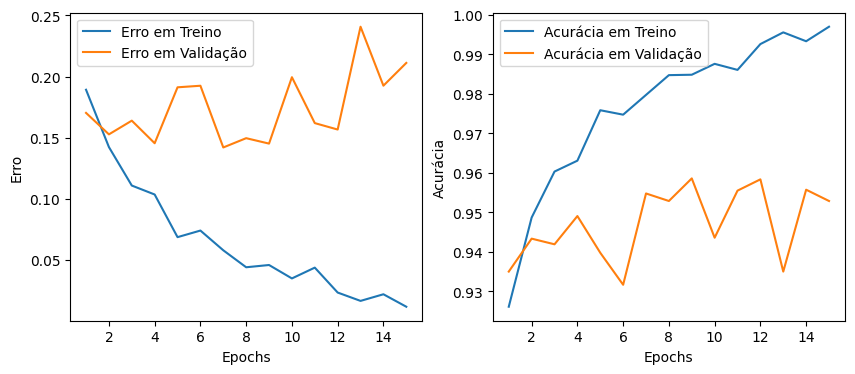

In [266]:
# Época
epoch = range(1, len(train_loss_history_2)+1)

fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].plot(epoch, train_loss_history[2:], label = 'Erro em Treino')
ax[0].plot(epoch, val_loss_history, label = 'Erro em Validação')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Erro')
ax[0].legend()

ax[1].plot(epoch, train_acc_history[2:], label = 'Acurácia em Treino')
ax[1].plot(epoch, val_acc_history, label = 'Acurácia em Validação')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Acurácia')
ax[1].legend()

In [269]:
# Função para o plot da confusion matrix
def plot_cm(labels, predictions):

    conf_numpy = confusion_matrix(labels, predictions)
    conf_df = pd.DataFrame(conf_numpy, index = class_names, columns = class_names)
    plt.figure(figsize = (8,7))
    sns.heatmap(conf_df, annot = True, fmt = "d", cmap = "BuPu")
    plt.title('Confusion Matrix', fontsize = 15)
    plt.ylabel('Valor Real', fontsize = 14)
    plt.xlabel('Valor Previsto', fontsize = 14)

In [270]:
# Função para avaliar o modelo
def evaluate_model(model, dataloader, device):
    
    # Coloca o modelo em modo de avaliação
    modelo.eval()   
    
    # Listas
    true_labels = []
    pred_labels = []
    
    # Faz as previsões a partir dos dados
    for inputs, labels in dataloader:
        
        # Envia imagens e labels para o device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward
        with torch.no_grad():
            outputs = modelo(inputs)
            _, preds = torch.max(outputs, 1)

        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

    return true_labels, pred_labels

In [272]:
# Extrai valores reais e previsões de labels
true_labels, pred_labels = evaluate_model(modelo, dataloaders['valid'], DEVICE)

In [273]:
# Calcula a confusion matrix
cm_val = confusion_matrix(true_labels, pred_labels)
a_val = cm_val[0,0]
b_val = cm_val[0,1]
c_val = cm_val[1,0]
d_val = cm_val[1,1]

In [274]:
# Calcula as métricas de performance

# Accuracy
acc_val = (a_val + d_val) / (a_val + b_val + c_val + d_val)  

# Error rate
error_rate_val = 1 - acc_val 

# Sensitivity
sen_val = d_val/(d_val + c_val) 

# Specificity
sep_val = a_val/(a_val + b_val) 

# Precision
precision_val = d_val / (b_val + d_val) 

# F1 score
F1_val = (2 * precision_val * sen_val) / (precision_val + sen_val)  

# Coeficiente de Correlação de Matthews
MCC_val = (d_val*a_val-b_val*c_val) / (np.sqrt((d_val+b_val)*(d_val+c_val)*(a_val+b_val)*(a_val+c_val))) 

In [275]:
# Print
print("\n Sensitivity em validação:", sen_val,
      "\n Specificity em validação:", sep_val,
      "\n Accuracy em validação:", acc_val,
      "\n Error rate em validação:", error_rate_val,
      "\n Precision em validação:", precision_val,
      "\n F1 score em validação:", F1_val,
      "\n Matthews Correlation Coefficient (MCC) em validação:", MCC_val)


 Sensitivity em validação: 0.9321548017200191 
 Specificity em validação: 0.973421926910299 
 Accuracy em validação: 0.9528571428571428 
 Error rate em validação: 0.04714285714285715 
 Precision em validação: 0.9720976581963129 
 F1 score em validação: 0.9517073170731707 
 Matthews Correlation Coefficient (MCC) em validação: 0.9064610206654348


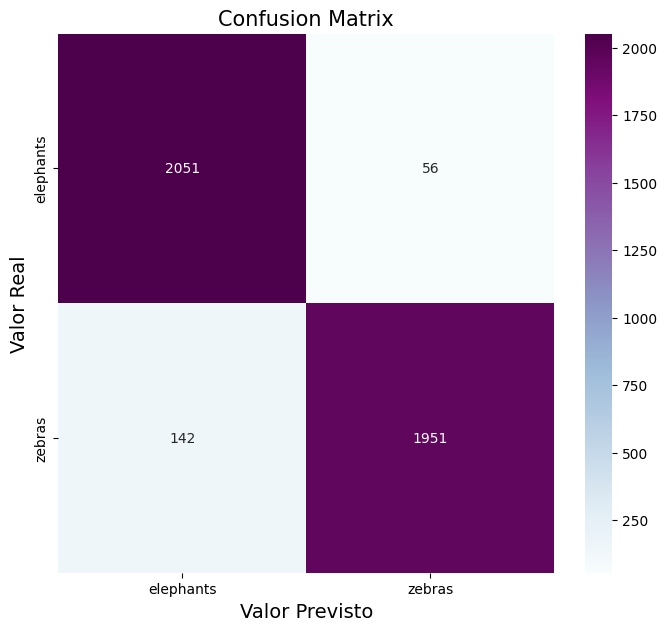

In [278]:
# Confusion matrix
plot_cm(true_labels, pred_labels)

In [280]:
# Salva o modelo
torch.save(modelo, '../models/modelo_vit_custom_linformer.pt')

# Predizendo dados novos

In [315]:
new_data_path = '../Data/zebra_elephants/test/'
new_imgs_list = os.listdir(new_data_path)

In [312]:
imagem_teste = os.path.join(new_data_path, new_imgs_list[1])

In [318]:
dataset.mean

tensor([0.4248, 0.4611, 0.4364])

In [316]:
datasets.ImageFolder(new_data_path)

Dataset ImageFolder
    Number of datapoints: 5999
    Root location: ../Data/zebra_elephants/test/

In [320]:
novos_dados = datasets.ImageFolder(new_data_path,transform=transforms.Compose([transforms.Resize((224, 224)), 
                                                            transforms.ToTensor(),
                                                            transforms.Normalize(dataset.mean.tolist(), 
                                                                                 dataset.std.tolist())]))


In [321]:
novos_dados

Dataset ImageFolder
    Number of datapoints: 5999
    Root location: ../Data/zebra_elephants/test/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.42477431893348694, 0.4611095190048218, 0.43636345863342285], std=[0.25282105803489685, 0.2683083117008209, 0.30349212884902954])
           )

In [322]:
novos_dados_dataloader = DataLoader(novos_dados, batch_size=64, shuffle=False, num_workers = 6)

In [327]:
# Extrai valores reais e previsões de labels
true_labels, pred_labels = evaluate_model(modelo, novos_dados_dataloader, DEVICE)

In [356]:
files_dataloader_list = novos_dados_dataloader.dataset.__dict__["imgs"]

In [362]:
image_names = [os.path.basename(path) for path, label in files_dataloader_list]

In [404]:
teste = pd.DataFrame({'id': image_names, 'label': pred_labels})

In [405]:
teste

,id,label
0,ASG0014ip3_0.jpeg,0
1,ASG0014ip3_1.jpeg,0
2,ASG0014ip5_1.jpeg,0
3,ASG0014ip9_0.jpeg,0
4,ASG0014ipc_0.jpeg,0
...,...,...
5994,ASG001g7r0_1.jpeg,0
5995,ASG001g7r0_2.jpeg,0
5996,ASG001g7ry_1.jpeg,0
5997,ASG001g7sb_0.jpeg,0


In [407]:
resultado = teste.groupby('label').agg(Contagem = ('id','count')).reset_index()


resultado['label'] = resultado['label'].map({0: 'elephants', 1: 'zebras'})

resultado

,label,Contagem
0,elephants,3071
1,zebras,2928


In [408]:
teste.to_csv('Submission.csv', index = False)